This notebook is dedicated to conducting exploratory data analysis (EDA) and experimenting with various feature engineering techniques. For details on the final model and chosen features, please refer to the ML_pipeline notebook.

In [2]:
from oceanwave_forecast import data_manager
from oceanwave_forecast import data_pipeline

from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.detrend import Detrender, Deseasonalizer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA, AutoARIMA

from sktime.transformations.compose import ColumnEnsembleTransformer

import os
import importlib
importlib.reload(data_manager)
importlib.reload(data_pipeline)

import hvplot.pandas  # registers the .hvplot accessor
import holoviews as hv
hv.extension('bokeh')


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:

# Define the paths to the three .txt files
folder1_txt = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\Standard meteorological data 2024\\46088h2024.txt'
data_ocean = data_manager.extract_raw_data(folder1_txt)
data_ocean.head()

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST  ...          DEWP      VIS     TIDE
count  52650.000000  52650.000000  52650.000000  ...  52650.000000  52650.0  52650.0
mean     194.421026      4.96

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
datetime,,,,,,,,,,,,,
2024-01-01 00:00:00,90.0,2.3,3.5,99.00,99.0,99.00,999.0,1022.9,7.7,9.2,5.6,99.0,99.0
2024-01-01 00:10:00,103.0,2.4,3.2,0.15,99.0,4.45,999.0,1022.9,7.6,9.2,5.4,99.0,99.0
2024-01-01 00:20:00,95.0,2.1,3.1,99.00,99.0,99.00,999.0,1023.0,7.6,9.2,5.4,99.0,99.0
2024-01-01 00:30:00,95.0,1.7,2.2,99.00,99.0,99.00,999.0,1023.0,7.6,9.2,5.5,99.0,99.0
2024-01-01 00:40:00,98.0,1.4,2.2,0.16,99.0,4.67,999.0,1023.0,7.5,9.1,5.3,99.0,99.0


In [4]:
numerical_cols, categorical_cols = data_manager.DATAF_separate_columns(data_ocean)
disc_numerical_cols, conti_numerical_cols = data_manager.DATAF_separate_num_columns(data_ocean,numerical_cols, unique_threshold=20)


print("Number of Discrete Numerical Variables:", len(disc_numerical_cols))
print("Number of Continuous Numerical Variables:", len(conti_numerical_cols))
print("Number of Categorical Variables:", len(categorical_cols))
print(disc_numerical_cols)

Number of Discrete Numerical Variables: 2
Number of Continuous Numerical Variables: 11
Number of Categorical Variables: 0
['VIS', 'TIDE']


In [5]:
# These two cols are not needed for the analysis
print(data_ocean['TIDE'].unique())
print(data_ocean['VIS'].unique())
# data_ocean.drop(columns=['TIDE', 'VIS'], inplace=True)


[99.]
[99.]


CHECKING THE MISSING DATA USING OUTLIERS

In [6]:
# Notes:
# Remove the MWD cause 80% of data is outside the range
# Replace the WDIR 53 samples outside the range with NaN
# Replace the WSPD,GST,DPD,WVHT,APD samples with value 99.  with NaN
# Replace the PRES samples with value 9999. with NaN
# Replace the ATMP,WTMP,DEWP samples with value 999. with NaN


# 1) Separate the two directional columns
dir_cols   = ['WDIR', 'MWD']
dir_data   = data_ocean[dir_cols]
other_data = data_ocean.drop(columns=dir_cols)
n_total    = len(data_ocean)

# 2) Range check for 0–360° on the direction columns
for col in dir_cols:
    bad = dir_data[(dir_data[col] < 0) | (dir_data[col] > 360)][col]
    cnt = len(bad)
    pct = cnt / n_total * 100
    print(f"{col}: {cnt} samples ({pct:.2f}%) outside 0–360°")

# 3) 2σ outlier detection on the remaining columns
means = other_data.mean()
stds  = other_data.std()
outliers_mask = other_data.sub(means).abs().gt(2 * stds)

for col in other_data.columns:
    outlier_samples = other_data.loc[outliers_mask[col], col]
    cnt       = len(outlier_samples)
    pct       = cnt / n_total * 100
    n_unique  = outlier_samples.nunique()
    is_disc   = n_unique <= 20

    print(f"\n{col}:")
    print(f"  Total outliers      = {cnt} ({pct:.2f}%)")
    print(f"  Unique outlier vals = {n_unique} → "
          f"{'DISCRETE' if is_disc else 'CONTINUOUS'}")
    print(f"  Outlier values (up to first 20):\n    "
          f"{outlier_samples.unique()[:20]}")




WDIR: 53 samples (0.10%) outside 0–360°
MWD: 42318 samples (80.38%) outside 0–360°

WSPD:
  Total outliers      = 1462 (2.78%)
  Unique outlier vals = 67 → CONTINUOUS
  Outlier values (up to first 20):
    [12.8 12.7 99.  13.1 12.9 12.6 13.2 13.3 13.6 16.7 16.  15.2 14.4 15.3
 15.5 13.  13.5 14.2 16.3 14.5]

GST:
  Total outliers      = 1731 (3.29%)
  Unique outlier vals = 98 → CONTINUOUS
  Outlier values (up to first 20):
    [15.5 15.4 15.8 15.9 99.  16.7 16.8 16.  16.4 15.3 15.7 15.6 16.2 17.1
 16.9 16.5 17.6 22.  19.6 20.4]

WVHT:
  Total outliers      = 0 (0.00%)
  Unique outlier vals = 0 → DISCRETE
  Outlier values (up to first 20):
    []

DPD:
  Total outliers      = 8215 (15.60%)
  Unique outlier vals = 25 → CONTINUOUS
  Outlier values (up to first 20):
    [3.45 4.   3.7  3.57 3.85 4.17 4.55 4.35 4.76 3.23 3.03 3.13 2.94 3.33
 2.6  5.26 5.   2.86 2.74 5.56]

APD:
  Total outliers      = 0 (0.00%)
  Unique outlier vals = 0 → DISCRETE
  Outlier values (up to first 20):
    []



In [7]:
col_name = 'WVHT'

# the periods to plot
periods = [
    ('2024-01-01', '2024-01-01', 'First Day'),
    ('2024-01-01', '2024-01-07', 'First Week'),
    ('2024-01-01', '2024-03-31', 'Three Months'),
]

# collect HoloViews plots
plots = []
for start, end, label in periods:
    segment = data_ocean.loc[start:end, col_name]
    p = segment.hvplot(
        kind='line',
        marker='o',
        title=f"{col_name}: {label}",
        ylabel=col_name,
        xlabel='Time',
        width=800,       # optionally tweak size
        height=300
    )
    plots.append(p)

# stack them vertically
layout = hv.Layout(plots).cols(1)

# display in a Jupyter notebook or Panel app
layout

:Layout
   .Curve.WVHT.I   :Curve   [datetime]   (WVHT)
   .Curve.WVHT.II  :Curve   [datetime]   (WVHT)
   .Curve.WVHT.III :Curve   [datetime]   (WVHT)

In [8]:
# Applying two trasnfomratin
# Removing two cols
# Resampling on hourly basis
missing_map = {
    # wind & gust & dominant-period wave:  99 → NaN
    'WSPD': 99.0,
    'GST':  99.0,
    'DPD':  99.0,
    'WVHT': 99.0,
    'APD': 99.0,

    # pressure: 9999 → NaN
    'PRES': 9999.0,

    # air, water & dew temps: 999 → NaN
    'ATMP': 999.0,
    'WTMP': 999.0,
    'DEWP': 999.0,
}
# instantiate and transform
mv_marker = data_pipeline.MissingValueMarker(missing_map)
deg2rad = data_pipeline.DegreeToCyclic(columns=['WDIR', 'MWD'])

data_ocean_clean = mv_marker.transform(data_ocean)
data_ocean_clean = deg2rad.transform(data_ocean_clean)
data_ocean_clean = data_ocean_clean.drop(columns=['TIDE', 'VIS'])
data_ocean_hourly = data_ocean_clean.resample('H').mean()

data_ocean_hourly.info()
data_ocean_hourly.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Freq: h
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   WSPD      8776 non-null   float64
 1   GST       8776 non-null   float64
 2   WVHT      8773 non-null   float64
 3   DPD       5425 non-null   float64
 4   APD       8773 non-null   float64
 5   PRES      8776 non-null   float64
 6   ATMP      8776 non-null   float64
 7   WTMP      8776 non-null   float64
 8   DEWP      8776 non-null   float64
 9   WDIR_sin  8772 non-null   float64
 10  WDIR_cos  8772 non-null   float64
 11  MWD_sin   5425 non-null   float64
 12  MWD_cos   5425 non-null   float64
dtypes: float64(13)
memory usage: 960.8 KB


C:\Users\akashv22\AppData\Local\Temp\ipykernel_16896\1088025727.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,DEWP,WDIR_sin,WDIR_cos,MWD_sin,MWD_cos
datetime,,,,,,,,,,,,,
2024-01-01 00:00:00,1.900000,2.733333,0.155,NaN,4.560,1022.983333,7.583333,9.183333,5.416667,0.992432,-0.101365,NaN,NaN
2024-01-01 01:00:00,1.083333,1.683333,0.175,NaN,5.225,1023.283333,7.450000,9.150000,5.416667,0.935289,-0.121574,NaN,NaN
2024-01-01 02:00:00,0.366667,0.983333,0.150,NaN,5.255,1023.466667,7.316667,9.116667,5.416667,-0.150897,0.310470,NaN,NaN
2024-01-01 03:00:00,1.350000,1.950000,0.135,NaN,5.945,1023.533333,7.383333,9.100000,5.533333,0.576116,0.796695,NaN,NaN
2024-01-01 04:00:00,1.733333,2.733333,0.130,NaN,6.345,1023.633333,7.150000,9.100000,5.433333,0.561883,0.778324,NaN,NaN


In [9]:
# Calculate the number of NaN values and their percentage for each column
nan_summary = data_ocean_hourly.isnull().sum().to_frame(name='NaN Count')
nan_summary['Percentage (%)'] = (nan_summary['NaN Count'] / len(data_ocean_hourly)) * 100

# Display the summary
print(nan_summary)



          NaN Count  Percentage (%)
WSPD              8        0.091075
GST               8        0.091075
WVHT             11        0.125228
DPD            3359       38.239982
APD              11        0.125228
PRES              8        0.091075
ATMP              8        0.091075
WTMP              8        0.091075
DEWP              8        0.091075
WDIR_sin         12        0.136612
WDIR_cos         12        0.136612
MWD_sin        3359       38.239982
MWD_cos        3359       38.239982


In [11]:
# Notes:
# WSPD and GST are wind speed and gust speed have similar patterns
# Drop the dominant period wave (DPD) column as we have APD


col_names = ['WDIR_sin','WDIR_cos', 'WSPD', 'GST', 'WVHT', 'APD', 'DPD','MWD_sin','MWD_cos','PRES', 'ATMP', 'WTMP', 'DEWP']

# fixed 3‑month window
start, end = '2024-01-01', '2024-06-30'
ts_start, ts_end = pd.to_datetime(start), pd.to_datetime(end)

plots = []
for col_name in col_names:
    # slice the hourly data
    segment = data_ocean_hourly[col_name].loc[start:end]
    # backfill imputation
    imputed = segment.fillna(method='bfill')
    
    # 1) blue line of the imputed series
    main_curve = imputed.hvplot(
        kind='line',
        line_color='blue',
        marker='.',
        title=f"{col_name} (Jan–Mar 2024) with Imputation",
        ylabel=col_name,
        xlabel='Time',
        width=900,
        height=300,
        xlim=(ts_start, ts_end)
    )

    # 2) red scatter at imputed points
    imputed_pts = imputed[segment.isna()].hvplot(
        kind='scatter',
        color='red',
        marker='o',
        size=6,
        legend=False
    )

    # 3) overlay and collect
    plots.append(main_curve * imputed_pts)

# stack vertically
layout = hv.Layout(plots).cols(1)

# display
layout

C:\Users\akashv22\AppData\Local\Temp\ipykernel_16896\911139783.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  imputed = segment.fillna(method='bfill')


:Layout
   .Overlay.WDIR_sin :Overlay
      .Curve.WDIR_sin   :Curve   [datetime]   (WDIR_sin)
      .Scatter.WDIR_sin :Scatter   [datetime]   (WDIR_sin)
   .Overlay.WDIR_cos :Overlay
      .Curve.WDIR_cos   :Curve   [datetime]   (WDIR_cos)
      .Scatter.WDIR_cos :Scatter   [datetime]   (WDIR_cos)
   .Overlay.WSPD     :Overlay
      .Curve.WSPD   :Curve   [datetime]   (WSPD)
      .Scatter.WSPD :Scatter   [datetime]   (WSPD)
   .Overlay.GST      :Overlay
      .Curve.GST   :Curve   [datetime]   (GST)
      .Scatter.GST :Scatter   [datetime]   (GST)
   .Overlay.WVHT     :Overlay
      .Curve.WVHT   :Curve   [datetime]   (WVHT)
      .Scatter.WVHT :Scatter   [datetime]   (WVHT)
   .Overlay.APD      :Overlay
      .Curve.APD   :Curve   [datetime]   (APD)
      .Scatter.APD :Scatter   [datetime]   (APD)
   .Overlay.DPD      :Overlay
      .Curve.DPD   :Curve   [datetime]   (DPD)
      .Scatter.DPD :Scatter   [datetime]   (DPD)
   .Overlay.MWD_sin  :Overlay
      .Curve.MWD_sin   :Curve   [datetime]   (MWD_sin)
      .Scatter.MWD_sin :Scatter   [datetime]   (MWD_sin)
   .Overlay.MWD_cos  :Overlay
      .Curve.MWD_cos   :Curve   [datetime]   (MWD_cos)
      .Scatter.MWD_cos :Scatter   [datetime]   (MWD_cos)
   .Overlay.PRES     :Overlay
      .Curve.PRES   :Curve   [datetime]   (PRES)
      .Scatter.PRES :Scatter   [datetime]   (PRES)
   .Overlay.ATMP     :Overlay
      .Curve.ATMP   :Curve   [datetime]   (ATMP)
      .Scatter.ATMP :Scatter   [datetime]   (ATMP)
   .Overlay.WTMP     :Overlay
      .Curve.WTMP   :Curve   [datetime]   (WTMP)
      .Scatter.WTMP :Scatter   [datetime]   (WTMP)
   .Overlay.DEWP     :Overlay
      .Curve.DEWP   :Curve   [datetime]   (DEWP)
      .Scatter.DEWP :Scatter   [datetime]   (DEWP)

# PREPROCESSING AND IMPUTATION

In [12]:
processed_data = data_pipeline.preprocess_ocean_data(data_ocean)
processed_data.info()
# NOTE Truncate the processed data to only include the first 6 months (from Jan 1st to Jun 30th, 2024)
processed_data = processed_data.loc['2024-01-01':'2024-06-30']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Freq: h
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   WSPD      8776 non-null   float64
 1   GST       8776 non-null   float64
 2   WVHT      8773 non-null   float64
 3   APD       8773 non-null   float64
 4   PRES      8776 non-null   float64
 5   ATMP      8776 non-null   float64
 6   WTMP      8776 non-null   float64
 7   DEWP      8776 non-null   float64
 8   WDIR_sin  8772 non-null   float64
 9   WDIR_cos  8772 non-null   float64
 10  MWD_sin   5425 non-null   float64
 11  MWD_cos   5425 non-null   float64
dtypes: float64(12)
memory usage: 892.1 KB


D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


In [13]:
special_cols = ['MWD_sin', 'MWD_cos']
other_cols = [col for col in processed_data.columns if col not in special_cols]


auto_arima = AutoARIMA(
    # let it search p=1..5, q=0..5, d determined by unit‐root tests
    start_p=1, max_p=3,
    start_q=0, max_q=3,
    d=None,
    # no periodic seasonality for angle components
    seasonal=False,
    stepwise=True,
    information_criterion="aic",
    suppress_warnings=True,
    n_jobs=-1,
)

imputer_pipe = ColumnEnsembleTransformer(
    transformers=[
        # ARIMA imputer only on the special columns
        ("arima_imp", Imputer(method="forecaster", forecaster=auto_arima), special_cols),
        # ffill imputer on all the *other* columns
        ("ffill_imp", Imputer(method="ffill"),other_cols),
    ],
    remainder="passthrough",  # or "drop" if you don't want any extra cols
)


# Apply the imputation pipeline to processed_data
processed_data_imputed = imputer_pipe.fit_transform(processed_data)


c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [14]:

plots = []
for col_name in col_names:
    if col_name == 'DPD':
        continue
    # slice the hourly data
    segment = data_ocean_hourly[col_name].loc[start:end]
    # backfill imputation
    imputed = processed_data_imputed[col_name].loc[start:end]
    
    main_curve = imputed.hvplot(
        kind='line',
        line_color='blue',
        marker='.',
        title=f"{col_name} (Jan–Mar 2024) with Imputation",
        ylabel=col_name,
        xlabel='Time',
        width=900,
        height=300,
        xlim=(ts_start, ts_end)
    )

    # 2) red scatter at imputed points
    imputed_pts = imputed[segment.isna()].hvplot(
        kind='scatter',
        color='red',
        marker='o',
        size=6,
        legend=False
    )

    # 3) overlay and collect
    plots.append(main_curve * imputed_pts)

# stack vertically
layout = hv.Layout(plots).cols(1)

# display
layout

:Layout
   .Overlay.WDIR_sin :Overlay
      .Curve.WDIR_sin   :Curve   [datetime]   (WDIR_sin)
      .Scatter.WDIR_sin :Scatter   [datetime]   (WDIR_sin)
   .Overlay.WDIR_cos :Overlay
      .Curve.WDIR_cos   :Curve   [datetime]   (WDIR_cos)
      .Scatter.WDIR_cos :Scatter   [datetime]   (WDIR_cos)
   .Overlay.WSPD     :Overlay
      .Curve.WSPD   :Curve   [datetime]   (WSPD)
      .Scatter.WSPD :Scatter   [datetime]   (WSPD)
   .Overlay.GST      :Overlay
      .Curve.GST   :Curve   [datetime]   (GST)
      .Scatter.GST :Scatter   [datetime]   (GST)
   .Overlay.WVHT     :Overlay
      .Curve.WVHT   :Curve   [datetime]   (WVHT)
      .Scatter.WVHT :Scatter   [datetime]   (WVHT)
   .Overlay.APD      :Overlay
      .Curve.APD   :Curve   [datetime]   (APD)
      .Scatter.APD :Scatter   [datetime]   (APD)
   .Overlay.MWD_sin  :Overlay
      .Curve.MWD_sin   :Curve   [datetime]   (MWD_sin)
      .Scatter.MWD_sin :Scatter   [datetime]   (MWD_sin)
   .Overlay.MWD_cos  :Overlay
      .Curve.MWD_cos   :Curve   [datetime]   (MWD_cos)
      .Scatter.MWD_cos :Scatter   [datetime]   (MWD_cos)
   .Overlay.PRES     :Overlay
      .Curve.PRES   :Curve   [datetime]   (PRES)
      .Scatter.PRES :Scatter   [datetime]   (PRES)
   .Overlay.ATMP     :Overlay
      .Curve.ATMP   :Curve   [datetime]   (ATMP)
      .Scatter.ATMP :Scatter   [datetime]   (ATMP)
   .Overlay.WTMP     :Overlay
      .Curve.WTMP   :Curve   [datetime]   (WTMP)
      .Scatter.WTMP :Scatter   [datetime]   (WTMP)
   .Overlay.DEWP     :Overlay
      .Curve.DEWP   :Curve   [datetime]   (DEWP)
      .Scatter.DEWP :Scatter   [datetime]   (DEWP)

# ANALYSIS OF THE TARGET

In [15]:
from sktime.transformations.series.detrend import Detrender, Deseasonalizer
from sktime.transformations.compose import TransformerPipeline
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

In [16]:
#### Checking the deseasonalized data for seasonality:

#  from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal_period = seasonality_res.seasonal_periods

# # Apply STL decomposition
# decomposition = seasonal_decompose(col, model='additive', period=seasonal_period)

# # Extract components
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

# # Deseasonalized series = trend + residual
# # Handle NaN values that might appear at the beginning and end
# deseasonalized = trend + residual
# deseasonalized = deseasonalized.dropna()

# # Visualize the decomposition
# plt.figure(figsize=(12, 8))
# plt.subplot(5, 1, 1)
# plt.plot(col[:100], label='Original')
# plt.legend()
# plt.subplot(5, 1, 2)
# plt.plot(trend[:100], label='Trend')
# plt.legend()
# plt.subplot(5, 1, 3)
# plt.plot(seasonal[:100], label='Seasonality')
# plt.legend()
# plt.subplot(5, 1, 4)
# plt.plot(deseasonalized[:100], label='Deseasonalized')
# plt.legend()
# plt.subplot(5, 1, 5)
# plt.plot(residual[:100], label='Residual')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Check for seasonality in the deseasonalized data
# seasonality_res_after = data_manager.check_seasonality(deseasonalized, max_lag=24*3, confidence=0.05)
# print(f"Seasonality after removal: {seasonality_res_after.seasonal}")
# print(f"Seasonality period after removal (if any): {seasonality_res_after.seasonal_periods}")
# print(f"Seasonality period after removal (if any): {seasonality_res_after.seasonal_periods}")


=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -6.5026
Results: {'pvalue': 1.1519263826740688e-08, 'stationary': True, 'test_statistic': -6.502593796149434, 'used_lag': 50}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[24 37 49 61]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 4.4170259923875986e-11


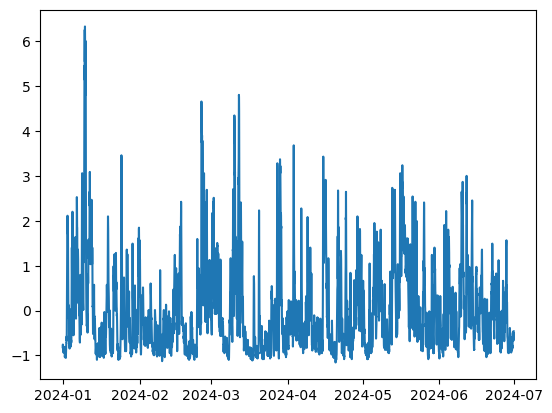


=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -5.9373
Results: {'pvalue': 2.3050856439624958e-07, 'stationary': True, 'test_statistic': -5.937268408888629, 'used_lag': 50}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[24 36 50]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 1.2501721968082412e-06


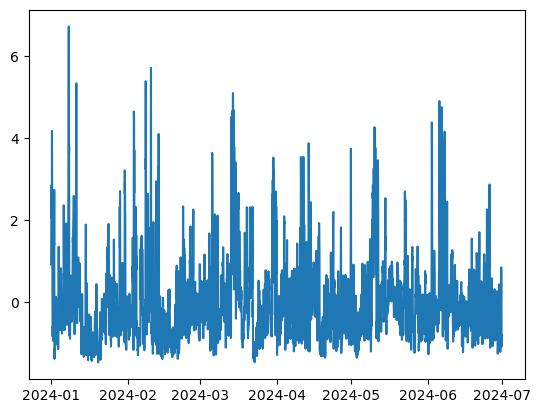

In [17]:

target_col = ['WVHT', 'APD']


for col in target_col:



    col_series = processed_data_imputed[col]
    pipe = TransformerPipeline(
            steps = [
                # ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=3))),
                # ("deseasonalizer", Deseasonalizer(sp=24)),
                # ("deseasonalizer2", Deseasonalizer(sp=24*2)),
                ('scale', TabularToSeriesAdaptor(StandardScaler()))
            ]
        )

    col_transf = pipe.fit_transform(col_series)

    data_manager.test_stationarity(col_transf, plot = False)
    mann_kendall_res = data_manager.check_trend(col_transf, confidence=0.05)
    print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} ")

    seasonality_res = data_manager.check_seasonality(col_transf, max_lag=24*3, confidence=0.05)
    print(f"Seasonality identified for: {seasonality_res.seasonal_periods}")

    hetero_res = data_manager.check_heteroscedastisticity(col_transf, confidence=0.05)
    print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

    plt.plot(col_transf)
    plt.show()



# ANALYSIS OF EXOG VARIABLES

MWD_sin

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -5.8568
Results: {'pvalue': 3.484868260136387e-07, 'stationary': True, 'test_statistic': -5.856792117605843, 'used_lag': 24}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: decreasing 
[49]
Seasonality identified for: 49
White Test for Heteroscedasticity: True with a p-value of 1.3550740655184857e-106


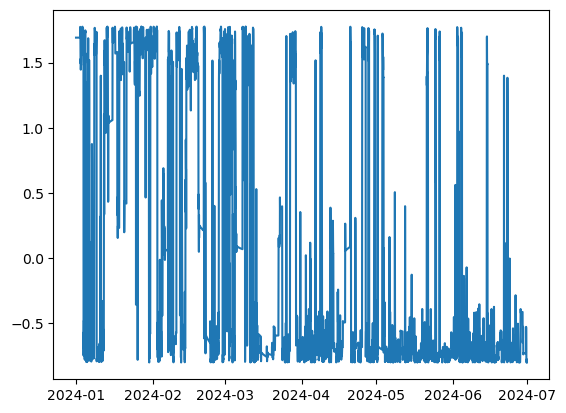

MWD_cos

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -7.4864
Results: {'pvalue': 4.625801574507973e-11, 'stationary': True, 'test_statistic': -7.486436989870942, 'used_lag': 30}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: decreasing 
[61 65]
Seasonality identified for: 61
White Test for Heteroscedasticity: True with a p-value of 3.1129822653858454e-102


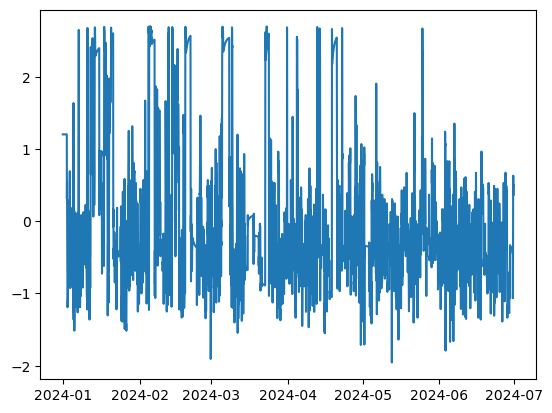

WSPD

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -8.7808
Results: {'pvalue': 2.379258885458067e-14, 'stationary': True, 'test_statistic': -8.78082983135054, 'used_lag': 22}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[24 49]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 0.0427042107145449


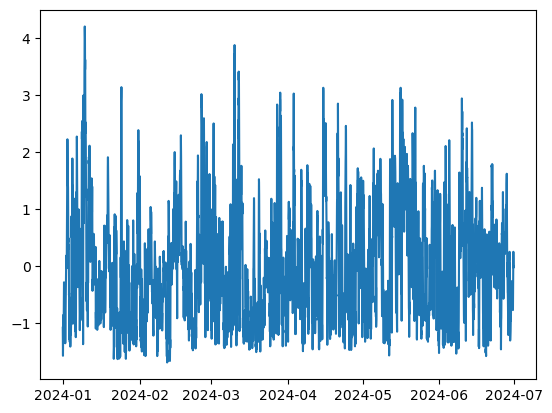

GST

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -8.6850
Results: {'pvalue': 4.1852943489723644e-14, 'stationary': True, 'test_statistic': -8.685049375466397, 'used_lag': 20}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[24 49]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 0.01811308177213882


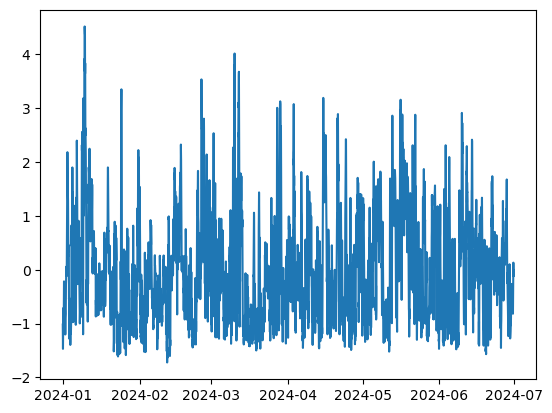

PRES

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -6.0004
Results: {'pvalue': 1.6624538569959565e-07, 'stationary': True, 'test_statistic': -6.000424363551698, 'used_lag': 50}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[]
The ACF has no local maximum for m < max_lag = 72. Try larger max_lag
Seasonality identified for: 0
White Test for Heteroscedasticity: True with a p-value of 1.0512800268557553e-72


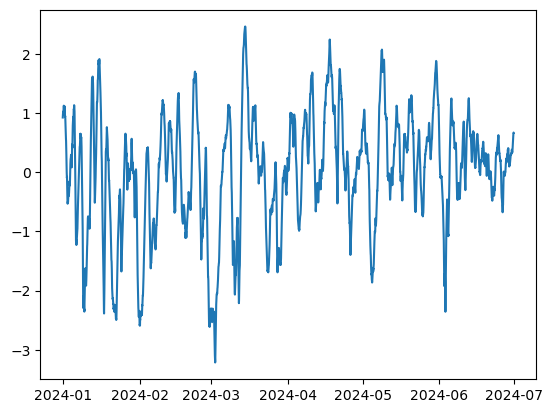

ATMP

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -3.2572
Results: {'pvalue': 0.016901183295541192, 'stationary': True, 'test_statistic': -3.2572453451583274, 'used_lag': 50}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[20 45 70]
Seasonality identified for: 20
White Test for Heteroscedasticity: True with a p-value of 8.192521422755905e-111


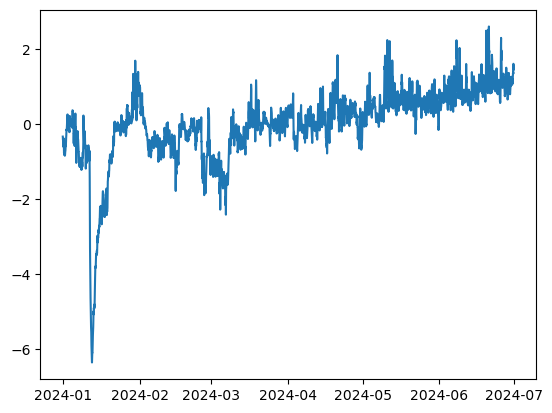

WTMP

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -0.4668
Results: {'pvalue': 0.898328116284242, 'stationary': False, 'test_statistic': -0.466831992807412, 'used_lag': 49}

Conclusion: The time series is Non-stationary at 5.0% significance level.
Null Hypothesis failed to reject
Mann-Kendalls: Trend: True | Direction: increasing 
[24 48]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 1.2454157502138745e-133


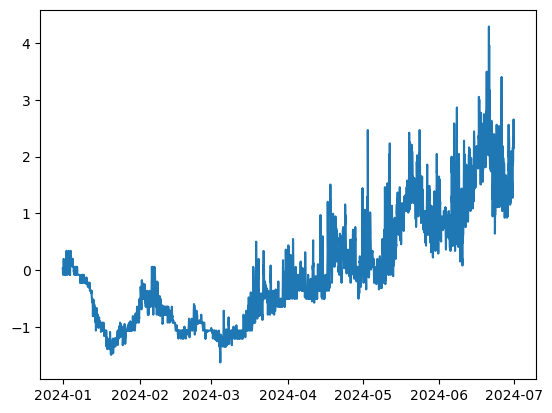

DEWP

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -3.7972
Results: {'pvalue': 0.002935844263446066, 'stationary': True, 'test_statistic': -3.7972240854222274, 'used_lag': 4}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[]
The ACF has no local maximum for m < max_lag = 72. Try larger max_lag
Seasonality identified for: 0
White Test for Heteroscedasticity: True with a p-value of 1.697891159639193e-145


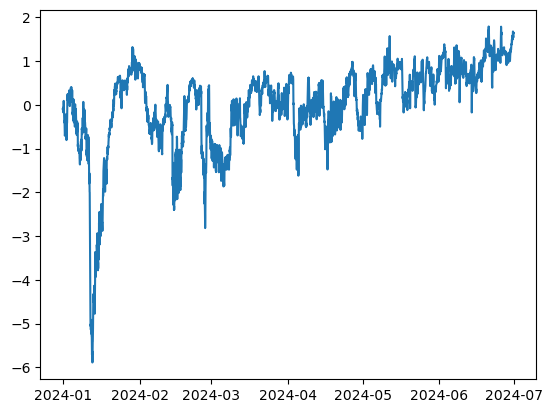

WDIR_sin

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -5.9532
Results: {'pvalue': 2.122729727004977e-07, 'stationary': True, 'test_statistic': -5.953233515367851, 'used_lag': 26}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: decreasing 
[22 27 43 63 71]
Seasonality identified for: 22
White Test for Heteroscedasticity: True with a p-value of 9.815376155143097e-29


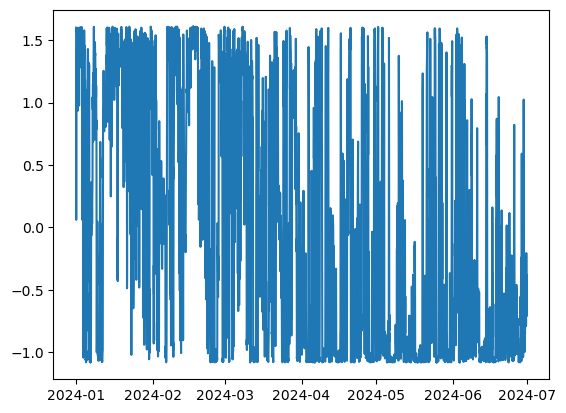

WDIR_cos

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -8.9967
Results: {'pvalue': 6.6651043562119674e-15, 'stationary': True, 'test_statistic': -8.99669249342096, 'used_lag': 15}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: decreasing 
[17 38 45 49 51 55 65]
Seasonality identified for: 17
White Test for Heteroscedasticity: True with a p-value of 5.2898178308078336e-76


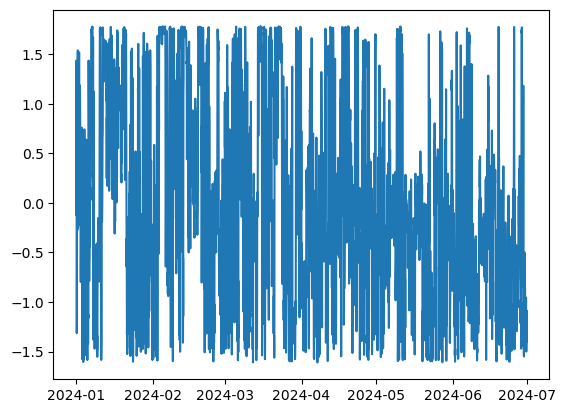

In [18]:
from statsmodels.tsa.stattools import adfuller
from sktime.param_est.stationarity import StationarityADF

exog_col = [col for col in processed_data_imputed.columns if col not in target_col]

for col in exog_col:
    print(col)
    series_col = processed_data_imputed[col]

    pipe = TransformerPipeline(
            steps = [
                ('scale', TabularToSeriesAdaptor(StandardScaler()))
            ]
        )

    col_transf = pipe.fit_transform(series_col)

    data_manager.test_stationarity(col_transf, plot = False)
    mann_kendall_res = data_manager.check_trend(col_transf, confidence=0.05)
    print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} ")

    seasonality_res = data_manager.check_seasonality(col_transf, max_lag=24*3, confidence=0.05)
    print(f"Seasonality identified for: {seasonality_res.seasonal_periods}")

    hetero_res = data_manager.check_heteroscedastisticity(col_transf, confidence=0.05)
    print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

    plt.plot(col_transf)
    plt.show()



# IMPUTING THE MWD_sin and MWD_cos

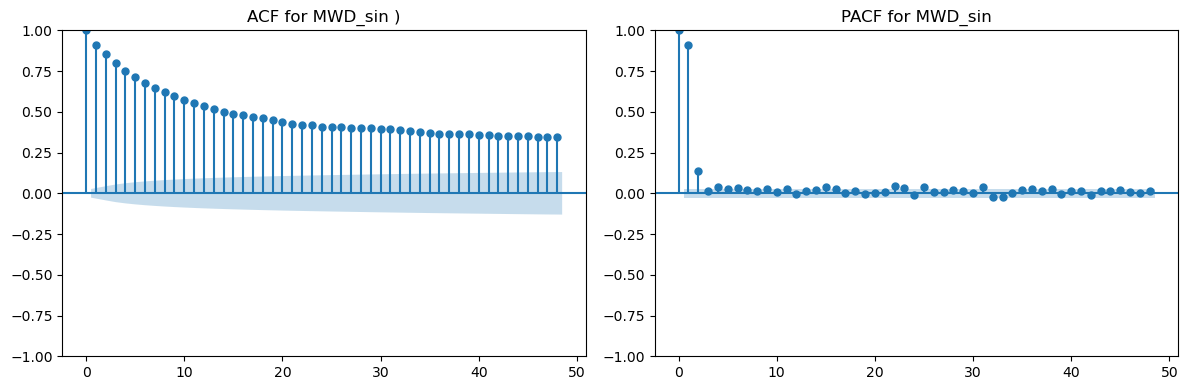

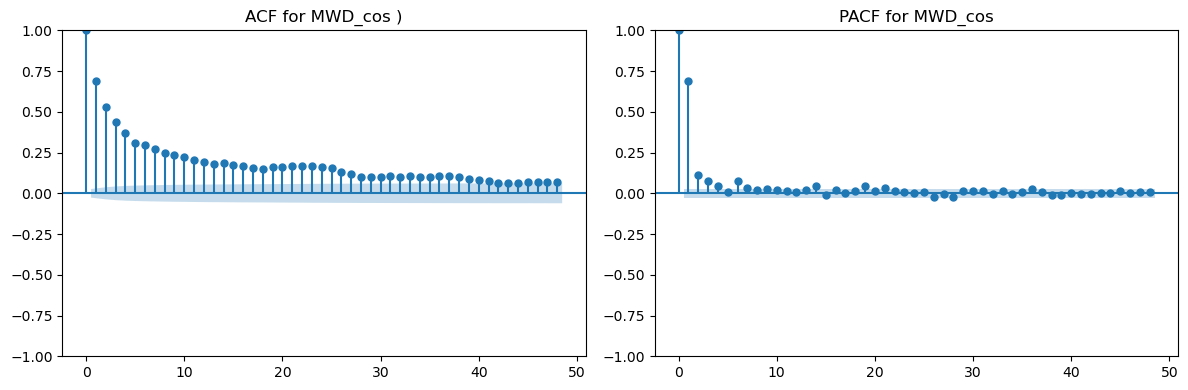

In [19]:
        
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for col in ['MWD_sin', 'MWD_cos']:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        # Plot ACF and PACF for the test set, dropping missing values
        plot_acf(data_ocean_hourly[col].dropna(), ax=axes[0], lags=48)
        axes[0].set_title(f'ACF for {col} )')
        plot_pacf(data_ocean_hourly[col].dropna(), ax=axes[1], lags=48)
        axes[1].set_title(f'PACF for {col}')
        plt.tight_layout()
        plt.show()